# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [6]:
df.printSchema()
df.describe('userId').show()
df.count()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910535|
|    min|                  |
|    max|                99|
+-------+------------------+



286500

In [7]:
df_cleaned = df.filter((df['userId'] != '') & (df['sessionId'].isNotNull()))

In [8]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# Apply the udf on the ts column
df_cleaned = df_cleaned.withColumn("time", get_time(df_cleaned.ts))

## Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [9]:
df_cleaned.createOrReplaceTempView("Sparkify_local_cleaned")
spark.sql('''
        SELECT DISTINCT(auth)
        FROM Sparkify_local_cleaned
''').show()
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



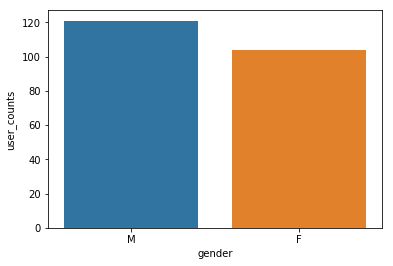

In [10]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()
sns.barplot(x='gender', y='user_counts', data=gender_count.toPandas())

In [ ]:
spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_counts
        FROM Sparkify_local_cleaned
''').show()

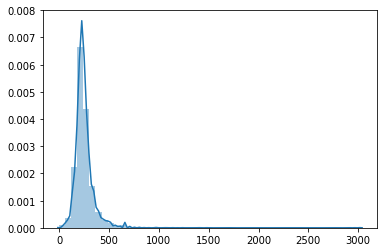

In [11]:
length_data = spark.sql('''
        SELECT length
        FROM Sparkify_local_cleaned
''')
sns.distplot(length_data.toPandas().dropna())

In [12]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



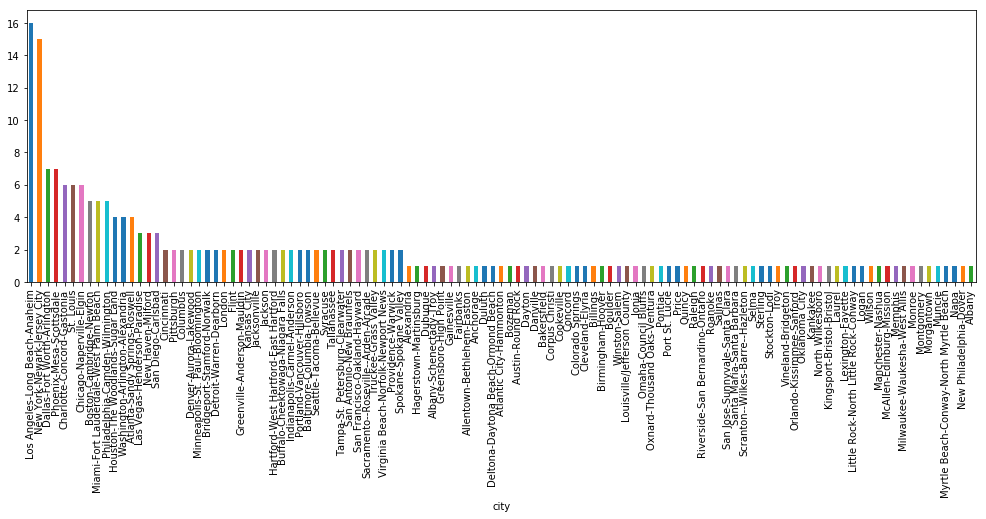

In [13]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()
location_count = location_count.join(location_count['location'].str.split(
    ',', expand=True).rename(columns={0: 'city', 1: 'state'})).drop('location', axis=1)
location_count.groupby('city')['user_counts'].sum().sort_values(
    ascending=False).plot(kind='bar', figsize=(17, 5))

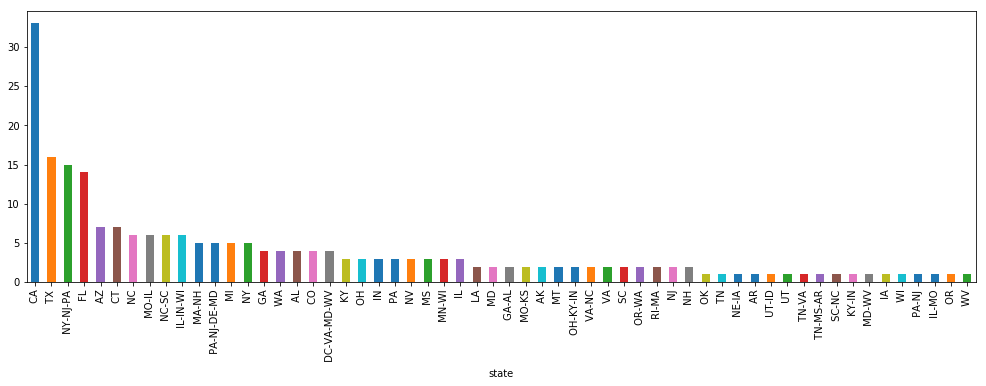

In [14]:
location_count.groupby('state')['user_counts'].sum().sort_values(
    ascending=False).plot(kind='bar', figsize=(17, 5))

In [15]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



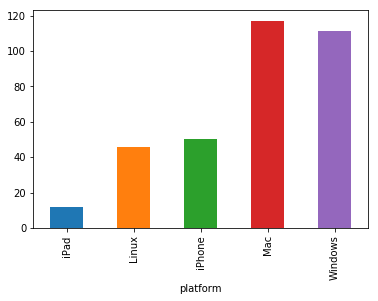

In [16]:
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import StringType

# Define UDFs to extract browser and platform information
get_browser = udf(lambda x: 'Firefox' if 'Firefox' in x else ('Chrome' if 'Chrome' in x else (
    'Safari' if 'Safari' in x else ('IE' if 'Trident' in x else None))), StringType())
get_platform = udf(lambda x: 'Windows' if 'Windows' in x else ('iPad' if 'iPad' in x else (
    'iPhone' if 'iPhone' in x else ('Mac' if 'Macintosh' in x else ('Linux' if 'X11' in x else None)))), StringType())

# Apply the UDFs to the DataFrame
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY userAgent
        ORDER BY user_counts DESC
''')
userAgent_count = userAgent_count.withColumn(
    'browser', get_browser(col('userAgent')))
userAgent_count = userAgent_count.withColumn(
    'platform', get_platform(col('userAgent')))

# Group by browser and platform and count
browser_data = userAgent_count.groupBy(
    'browser').sum('user_counts').orderBy('browser')
platform_data = userAgent_count.groupBy(
    'platform').sum('user_counts').orderBy('platform')

# Convert the Spark DataFrames to Pandas for plotting
browser_data_pd = browser_data.toPandas()
platform_data_pd = platform_data.toPandas()

# Plot the data
browser_data_pd.set_index(
    'browser')['sum(user_counts)'].sort_values().plot(kind='bar')
platform_data_pd.set_index('platform')[
    'sum(user_counts)'].sort_values().plot(kind='bar')

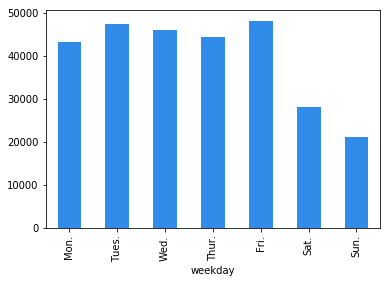

In [17]:
from pyspark.sql.functions import dayofmonth, hour, date_format

# Convert the 'time' column to a timestamp type
time_data = spark.sql('''
        SELECT to_timestamp(time) as time, userId
        FROM Sparkify_local_cleaned
''')

# Extract the weekday, day, and hour from the timestamp
time_data = time_data.withColumn('weekday', date_format('time', 'E'))
time_data = time_data.withColumn('day', dayofmonth('time'))
time_data = time_data.withColumn('hour', hour('time'))

# Group by weekday, day, and hour and count
time_data.groupBy('weekday').count().orderBy('weekday').show()
time_data.groupBy('day').count().orderBy('day').show()
time_data.groupBy('hour').count().orderBy('hour').show()

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [19]:
df_cleaned.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [21]:
# Define the flag event udf to transform event to 0 or 1
flag_event = udf(lambda x: 1 if x ==
                 'Cancellation Confirmation' else 0, IntegerType())
# define the current churn or not state
df_cleaned_cancel = df_cleaned.withColumn('Churn_state', flag_event('page'))
# Mark the user who have churned event
userwindow = Window.partitionBy('userId').rangeBetween(
    Window.unboundedPreceding, Window.unboundedFollowing)
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'Churn', fmax('Churn_state').over(userwindow))
df_cleaned_cancel.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10-08 12:58:54', Churn_state=0, Churn=0)]

In [22]:
df_cleaned_cancel.dropDuplicates(['userId']).select(
    'Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

In [23]:
# Auth
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(
    ["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



In [26]:
# Gender
df_cleaned_cancel.dropDuplicates(["userId", "gender"]).groupby(
    ["Churn", "gender"]).count().sort("Churn").show()
proportions_ztest([32, 20], [121, 104], alternative='two-sided')
# In males, churn rate is 0.264 which is 0.192 in females, but the p-value is 0.2 over 0.05, so the gender has almost no effect on Churn or not.

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    0|     M|   89|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



(1.2800974409737422, 0.20051086855629463)

In [28]:
# Length
df_cleaned_cancel.select(["Churn", "length"]).groupby(["Churn"]).agg(avg('length').alias('mean_length'),
                                                                     stddev('length').alias(
                                                                         'stdev_length'),
                                                                     fmax('length').alias(
                                                                         'max_length'),
                                                                     fmin('length').alias('min_length')).show()

+-----+------------------+------------------+----------+----------+
|Churn|       mean_length|      stdev_length|max_length|min_length|
+-----+------------------+------------------+----------+----------+
|    1|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
|    0|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
+-----+------------------+------------------+----------+----------+



In [30]:
# Level
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(
    ["Churn", "level"]).count().sort("Churn").show()
proportions_ztest([8, 44], [48, 177], alternative='two-sided')

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



(-1.194176507959015, 0.23240893045643263)

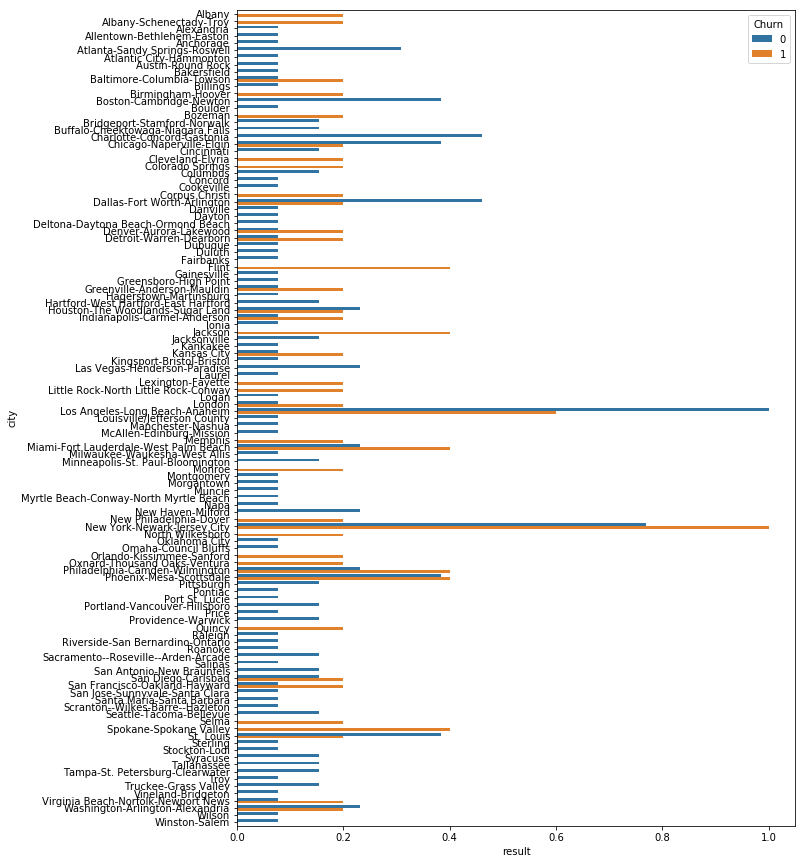

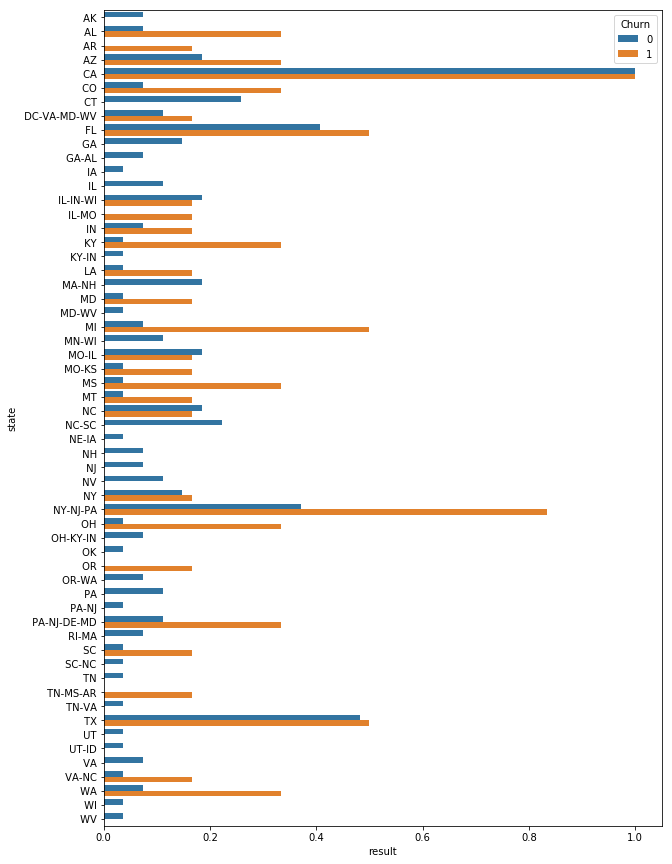

In [32]:
from pyspark.sql.functions import split, when, col, min, max
from pyspark.sql.window import Window

# Define a function to normalize data


def normalize_data(df, groupby_cols, count_col):
    window = Window.partitionBy(groupby_cols[0])
    df = df.withColumn('min', min(count_col).over(window))
    df = df.withColumn('max', max(count_col).over(window))
    df = df.withColumn('result', (col(count_col) -
                       col('min')) / (col('max') - col('min')))
    return df


# Split the 'location' column into 'city' and 'state'
split_city_state = split(df_cleaned_cancel['location'], ',')
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'city', split_city_state.getItem(0))
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'state', split_city_state.getItem(1))

# Group by 'city' and 'Churn', and normalize the data
city_data = df_cleaned_cancel.dropDuplicates(
    ["userId"]).groupby(["city", "Churn"]).count().sort("city")
city_data = normalize_data(city_data, ["city", "Churn"], "count")

# Group by 'state' and 'Churn', and normalize the data
state_data = df_cleaned_cancel.dropDuplicates(
    ["userId"]).groupby(["state", "Churn"]).count().sort("state")
state_data = normalize_data(state_data, ["state", "Churn"], "count")

# Convert the Spark DataFrames to Pandas for plotting
city_data_pd = city_data.toPandas()
state_data_pd = state_data.toPandas()

# Plot the data
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(x="result", y="city", hue="Churn", data=city_data_pd, ax=ax)

fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(x="result", y="state", hue="Churn", data=state_data_pd, ax=ax)

+-----+--------------------+------+
|Churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    1|           Downgrade|   337|
|    0|           Downgrade|  1718|
|    1|               Error|    32|
|    0|               Error|   220|
|    0|                Help|  1215|
|    1|                Help|   239|
|    1|                Home|  1672|
|    0|                Home|  8410|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    0|            NextSong|191714|
|    1|            NextSong| 36394|
+-----+--------------------+------+
only showing top 20 rows



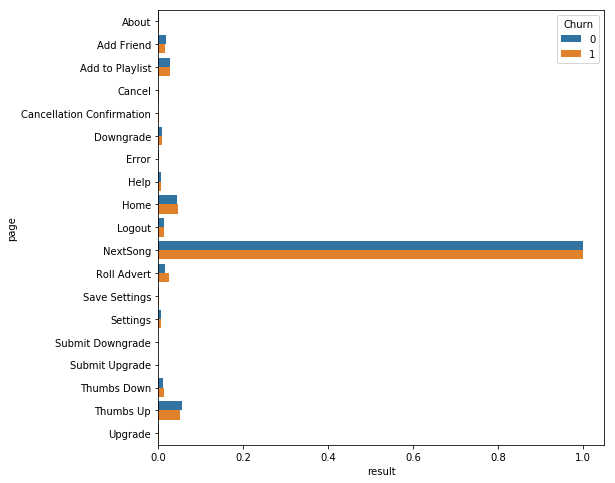

In [33]:
# Page
df_cleaned_cancel.select(["Churn", "page"]).groupby(
    ["Churn", "page"]).count().sort("page").show()
page_data = df_cleaned_cancel.select(["page", "Churn"]).groupby(
    ["page", "Churn"]).count().sort("page").toPandas()
page_data = normalize_data(page_data)
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="result", y="page", hue="Churn", data=page_data, ax=ax)

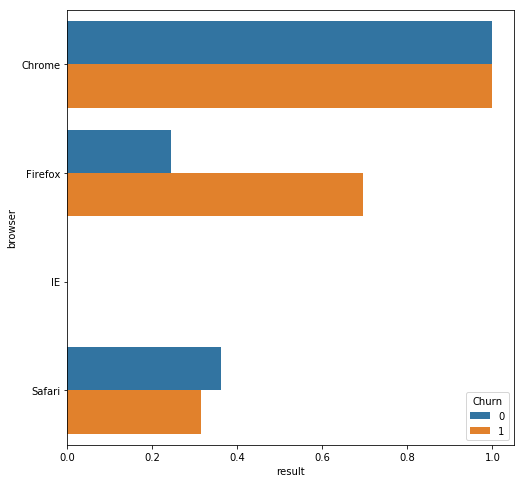

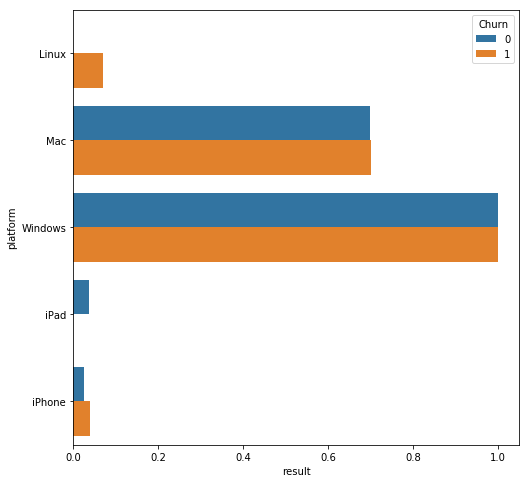

In [35]:
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import StringType

# Define UDFs to extract browser and platform information
get_browser = udf(lambda x: 'Firefox' if 'Firefox' in x else ('Chrome' if 'Chrome' in x else (
    'Safari' if 'Safari' in x else ('IE' if 'Trident' in x else None))), StringType())
get_platform = udf(lambda x: 'Windows' if 'Windows' in x else ('iPad' if 'iPad' in x else (
    'iPhone' if 'iPhone' in x else ('Mac' if 'Macintosh' in x else ('Linux' if 'X11' in x else None)))), StringType())

# Apply the UDFs to the DataFrame
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'browser', get_browser(col('userAgent')))
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'platform', get_platform(col('userAgent')))

# Group by browser and platform and count
browser_data = df_cleaned_cancel.groupBy(
    'browser', 'Churn').count().orderBy('browser')
platform_data = df_cleaned_cancel.groupBy(
    'platform', 'Churn').count().orderBy('platform')

# Normalize the data
browser_data = normalize_data(browser_data, ["browser", "Churn"], "count")
platform_data = normalize_data(platform_data, ["platform", "Churn"], "count")

# Convert the Spark DataFrames to Pandas for plotting
browser_data_pd = browser_data.toPandas()
platform_data_pd = platform_data.toPandas()

# Plot the data
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="result", y="browser", hue="Churn", data=browser_data_pd, ax=ax)

fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="result", y="platform", hue="Churn",
            data=platform_data_pd, ax=ax)

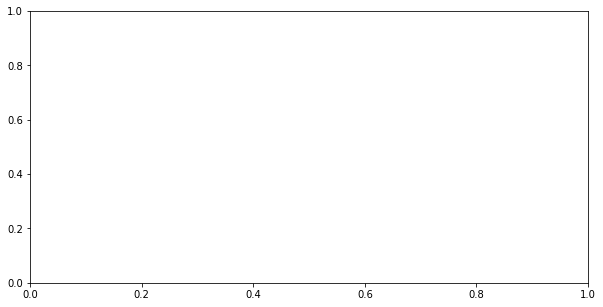

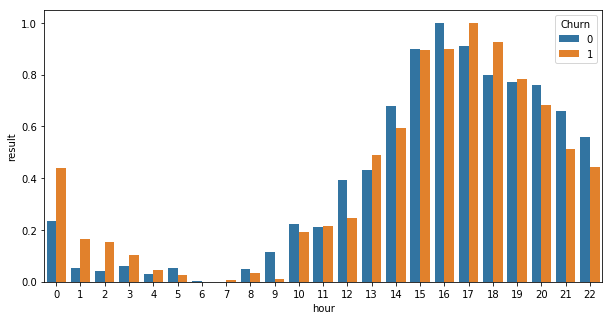

In [36]:
from pyspark.sql.functions import udf, hour, dayofmonth, date_format
from pyspark.sql.types import IntegerType

# Define UDFs to extract hour, day, and day of week
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).hour, IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).day, IntegerType())
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(
    x / 1000.0).strftime('%w'), IntegerType())

# Apply the UDFs to the DataFrame
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'hour', get_hour(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'day', get_day(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn(
    'dayofweek', get_weekday(df_cleaned_cancel.ts))

# Group by hour, day, and day of week and count
hour_data = df_cleaned_cancel.groupBy('Churn', 'hour').count().orderBy('hour')
day_data = df_cleaned_cancel.groupBy('Churn', 'day').count().orderBy('day')
dayofweek_data = df_cleaned_cancel.groupBy(
    'Churn', 'dayofweek').count().orderBy('dayofweek')

# Normalize the data
hour_data = normalize_data(hour_data, ["Churn", "hour"], "count")
day_data = normalize_data(day_data, ["Churn", "day"], "count")
dayofweek_data = normalize_data(
    dayofweek_data, ["Churn", "dayofweek"], "count")

# Convert the Spark DataFrames to Pandas for plotting
hour_data_pd = hour_data.toPandas()
day_data_pd = day_data.toPandas()
dayofweek_data_pd = dayofweek_data.toPandas()

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="hour", y="result", hue="Churn", data=hour_data_pd,
            ax=ax, order=list(map(lambda x: str(x), range(23))))

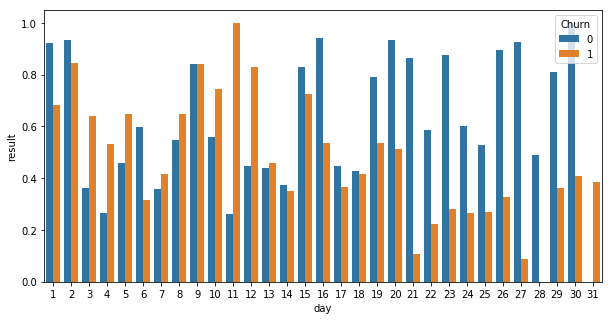

In [37]:
day_data = normalize_data(day_data)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="day", y="result", hue="Churn", data=day_data,
            ax=ax, order=list(map(lambda x: str(x), range(1, 32))))

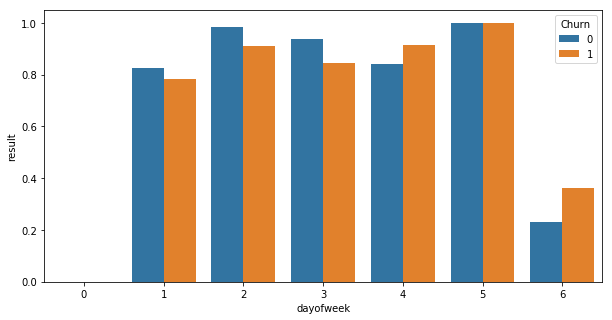

In [38]:
dayofweek_data = normalize_data(dayofweek_data)
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x="dayofweek", y="result", hue="Churn", data=dayofweek_data, ax=ax)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [39]:
# Categorical features
def label_encoding(col_name):
    '''
    transform categorical items to number
    '''
    temp = df_cleaned_cancel.select([col_name]).dropDuplicates().toPandas()
#     print(temp)
    label_dict = {val: str(idx)
                  for idx, val in enumerate(temp[col_name].tolist())}
    result = df_cleaned_cancel.dropDuplicates(['userId']).select(
        ['userId', col_name]).replace(label_dict, subset=col_name)
    return result


def get_categorical_features():
    '''
    join all categorical features together
    '''
    feature_gender = label_encoding('gender')
    feature_level = label_encoding('level')
    feature_browser = label_encoding('browser')
    feature_platform = label_encoding('platform')

    result = feature_gender.join(feature_level, on='userId', how='inner').\
        join(feature_browser, on='userId', how='inner').\
        join(feature_platform, on='userId', how='inner')
    return result


categorical_feature = get_categorical_features()
categorical_feature.show(2)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
+------+------+-----+-------+--------+
only showing top 2 rows



In [40]:
from pyspark.sql import Window
from pyspark.sql.functions import avg, stddev, max as fmax, min as fmin, first, sum, col, when, count


def get_numerical_features():
    '''
    join all numerical features together and implement Standscaler
    '''
    window = Window.partitionBy('userId')

    # Calculate features
    df = df_cleaned_cancel.withColumn('NextSong', when(col('page') == 'NextSong', 1).otherwise(0))\
                          .withColumn('Thumbs Up', when(col('page') == 'Thumbs Up', 1).otherwise(0))\
                          .withColumn('Thumbs Down', when(col('page') == 'Thumbs Down', 1).otherwise(0))\
                          .withColumn('Add to Playlist', when(col('page') == 'Add to Playlist', 1).otherwise(0))\
                          .withColumn('Add Friend', when(col('page') == 'Add Friend', 1).otherwise(0))\
                          .withColumn('Roll Advert', when(col('page') == 'Roll Advert', 1).otherwise(0))\
                          .withColumn('unique_song', count('song').over(window))\
                          .withColumn('total_song', count('song').over(window))\
                          .withColumn('unique_artist', count('artist').over(window))\
                          .withColumn('day_count', when(col('day') >= 15, 1).otherwise(0))\
                          .withColumn('total_count', count('*').over(window))\
                          .withColumn('dayofweek_count', when(col('dayofweek') < 5, 1).otherwise(0))

    # Aggregate features
    result = df.groupBy('userId').agg(avg('length').alias('mean_length'),
                                      stddev('length').alias('stdev_length'),
                                      fmax('length').alias('max_length'),
                                      fmin('length').alias('min_length'),
                                      sum('NextSong').alias('NextSong'),
                                      sum('Thumbs Up').alias('Thumbs Up'),
                                      sum('Thumbs Down').alias('Thumbs Down'),
                                      sum('Add to Playlist').alias(
                                          'Add to Playlist'),
                                      sum('Add Friend').alias('Add Friend'),
                                      sum('Roll Advert').alias('Roll Advert'),
                                      max('unique_song').alias('nunique_song'),
                                      max('total_song').alias('ntotal_song'),
                                      max('unique_artist').alias(
                                          'nunique_artist'),
                                      sum('day_count').alias('day_count'),
                                      max('total_count').alias('total_count'),
                                      sum('dayofweek_count').alias('dayofweek_count'))

    # Calculate percentages
    result = result.withColumn('month_percentage', col('day_count') / col('total_count'))\
                   .withColumn('week_percentage', col('dayofweek_count') / col('total_count'))

    return result

In [41]:
# Label
label = df_cleaned_cancel.select(['userId', 'Churn']).dropDuplicates()

In [42]:
from pyspark.sql.types import IntegerType, FloatType


def get_data_for_train():
    '''
    merge features and label together
    '''
    categorical_feature = get_categorical_features()
    numerical_feature = get_numerical_features()
    label = df_cleaned_cancel.select(['userId', 'Churn']).dropDuplicates()

    # Join all dataframes
    result = categorical_feature.join(
        numerical_feature, 'userId').join(label, 'userId')

    # Correct datatype
    int_cols = result.columns[1:5]
    float_cols = result.columns[5:-1]
    for col_name in int_cols + float_cols:
        result = result.withColumn(col_name,
                                   when(col(col_name).isNull(), 0).otherwise(col(col_name)).cast(IntegerType() if col_name in int_cols else FloatType()))

    return result


final_data = get_data_for_train()

# Backup final_data
final_data.write.mode('overwrite').json('final_data_new.json')
final_data = spark.read.json('final_data_new.json')

# Define categorical and numerical features
categorical_features = ['gender', 'level', 'browser', 'platform']
numerical_features = [
    col_name for col_name in final_data.columns if col_name not in categorical_features + ['Churn', 'userId']]

# Convert to Pandas for shape
check_df = final_data.toPandas()
check_df.shape

(204, 22)

In [43]:
# Implement standscaler on features
# implement standscaler
vector = VectorAssembler(inputCols=numerical_features,
                         outputCol='numerical_features')
temp = vector.transform(final_data)
scaler = StandardScaler(withMean=True, withStd=True,
                        inputCol='numerical_features', outputCol='features_scaled')
scaler_fit = scaler.fit(temp)
result_scaled = scaler_fit.transform(temp)

# add categorical features to feature vector

vector = VectorAssembler(inputCols=categorical_features +
                         ['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(result_scaled)
final_result = result_scaled.select(result_scaled.Churn.alias(
    'label'), result_scaled.all_features.alias('features'))

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [44]:
# Undersampling
def undersample(df):
    '''
    Implement undersample on dataset, return a balanced dataset.
    '''
    # size of minority class(0)
    minoritySize = df.where(df.label == '1').count()

    # two classes with the same size
    df_minority = df.where(df.label == '1')
    df_majority = df.where(df.label == '0').sample(
        1.0, seed=7).limit(minoritySize)

    # concatenate them together
    result = df_minority.union(df_majority)

    # shuffle data
    result = result.orderBy(rand())
    return result


balanced_data = undersample(final_result)
check_balanced_df = balanced_data.toPandas()
# check out
balanced_data.groupby(balanced_data.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   38|
|    1|   38|
+-----+-----+



In [45]:
# Split data to Train and Test
train, test = balanced_data.randomSplit([0.7, 0.3], seed=7)
test.count()

18

In [ ]:
# Baseline of models
# Initialize four models
clf_LR = LogisticRegression(maxIter=50)
clf_DT = DecisionTreeClassifier(seed=7)
clf_RF = RandomForestClassifier(seed=7)
clf_SVM = LinearSVC()
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
# collect results on the learners
all_results = {}
for clf in [clf_LR, clf_DT, clf_RF, clf_SVM]:
    model_results = {}
    # get the classifier name
    clf_name = clf.__class__.__name__

    # fit the dataset
    print(f'{clf_name} is training...')
    start = time.time()
    model = clf.fit(train)
    end = time.time()
    model_results['train_time'] = round(end-start, 6)

    # predict
    print(f'{clf_name} is predicting...')
    start = time.time()
    pred_test = model.transform(test)
    end = time.time()
    model_results['pred_time'] = round(end-start, 6)

    # metrics
    print(f'{clf_name} is evaluating...')
    model_results['f1_test'] = evaluator.evaluate(pred_test.select(
        'label', 'prediction'), {evaluator.metricName: 'f1'})
    print('Test F1-score: ', model_results['f1_test'])
    all_results[clf_name] = model_results

all_results_df = pd.DataFrame(all_results)
all_results_df.to_csv('baseline.csv')

LogisticRegression is training...
LogisticRegression is predicting...
LogisticRegression is evaluating...
Test F1-score:  0.3981481481481482
DecisionTreeClassifier is training...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is evaluating...
Test F1-score:  0.5916016350798959
RandomForestClassifier is training...
RandomForestClassifier is predicting...
RandomForestClassifier is evaluating...
Test F1-score:  0.4444444444444445
LinearSVC is training...


In [ ]:
all_results_df

In [ ]:
# Tuning
paramGrid = ParamGridBuilder().\
            addGrid(clf_SVM.maxIter, [10, 100, 1000]).\
            addGrid(clf_SVM.regParam, [0.01,0.1,10.0,100.0]).\
            build()
crossval = CrossValidator(estimator=clf_SVM,
                      estimatorParamMaps=paramGrid,
                      evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                      numFolds=3)
start = time.time()
cvModel_SVM = crossval.fit(train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')
Model tuning is done, spent 936.2487051486969s.
cvModel_SVM.avgMetrics

In [ ]:
# LogisticRegression
paramGrid = ParamGridBuilder().\
    addGrid(clf_LR.elasticNetParam, [0.1, 0.5, 1]).\
    addGrid(clf_LR.regParam, [0.01, 0.05, 0.1]).\
    build()

crossval = CrossValidator(estimator=clf_LR,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(
                              metricName="f1"),
                          numFolds=3)
start = time.time()
cvModel_LR = crossval.fit(train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')
cvModel_LR.avgMetrics

pred = cvModel_LR.transform(test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select(
    'label', 'prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label',
      'prediction'), {evaluator.metricName: "f1"})))
cvModel_LR.save('lr_model')

In [ ]:
# stacking model
def melt_predictions(train_datasets=True):
    '''
    melt predictions together.
    '''
    if train_datasets:
        dataset = train
    else:
        dataset = test
    svm_pred = cvModel_SVM.transform(dataset)
    lr_pred = cvModel_LR.transform(dataset)

    lr_frame = lr_pred.select(
        lr_pred.label, lr_pred.features, lr_pred.prediction.alias('lr_prediction'))
    svm_frame = svm_pred.select(
        svm_pred.features, svm_pred.prediction.alias('svm_prediction'))

    melt_data = lr_frame.join(svm_frame, on='features')

    # VectorAssembler
    vector = VectorAssembler(
        inputCols=['lr_prediction', 'svm_prediction'], outputCol='combine_features')
    temp = vector.transform(melt_data)
    stack_data = temp.select(
        temp.label, temp.combine_features.alias('features'))

    return stack_data


stack_data_train = melt_predictions()
stack_train, stack_test = stack_data_train.randomSplit([0.6, 0.4], seed=7)
paramGrid = ParamGridBuilder().\
    addGrid(clf_LR.elasticNetParam, [0.1, 0.5, 1]).\
    addGrid(clf_LR.regParam, [0.01, 0.05, 0.1]).\
    build()

stack_crossval = CrossValidator(estimator=clf_LR,
                                estimatorParamMaps=paramGrid,
                                evaluator=MulticlassClassificationEvaluator(
                                    metricName="f1"),
                                numFolds=3)
start = time.time()
cvModel_stack = stack_crossval.fit(stack_train)
end = time.time()
print(f'Model tuning is done, spent {end-start}s.')

# validation
pred = cvModel_stack.transform(stack_test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select(
    'label', 'prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label',
      'prediction'), {evaluator.metricName: "f1"})))

# test
stack_data_test = melt_predictions(train_datasets=False)
pred = cvModel_stack.transform(stack_data_test)

print('Accuracy: {}'.format(evaluator.evaluate(pred.select(
    'label', 'prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label',
      'prediction'), {evaluator.metricName: "f1"})))

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.